### Load the data

In [126]:
import pandas as pd

df = pd.read_csv("data/us-insurance-data.csv", sep=",")

### Display data types


In [127]:
display(df.head())


,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


### Display data summary

In [128]:
display(df.describe())


,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


### Handling missing data

In [129]:
# Check missing values
display(df.isnull().sum())

from sklearn.impute import SimpleImputer

# For numerical columns, fill missing values with the median
numerical_cols = ['age', 'bmi', 'children']
numerical_imputer = SimpleImputer(strategy='median')
df[numerical_cols] = numerical_imputer.fit_transform(df[numerical_cols])

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

### Encode categorical variables into numerical variables


In [130]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer

# Identify categorical and numerical columns
categorical_cols = ['sex', 'smoker', 'region']
numerical_cols = ['age', 'bmi', 'children']

# Create ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_cols),
        ('cat', OneHotEncoder(drop='first'), categorical_cols)
    ])


### Plot the distribution of charges

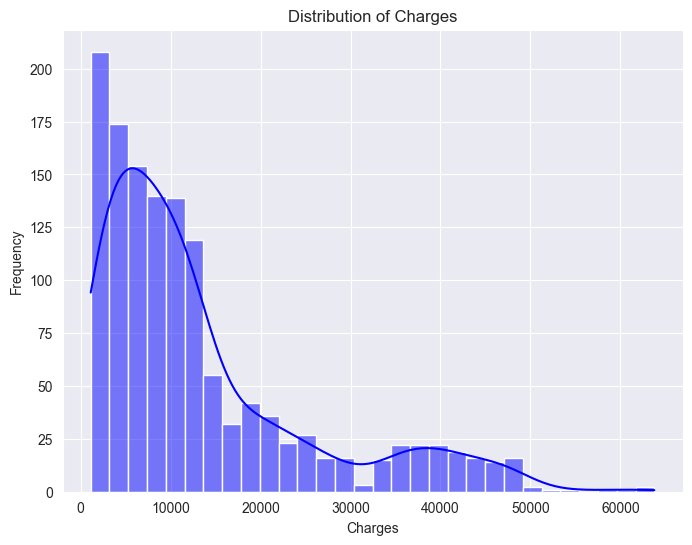

In [131]:
import seaborn as sns
import matplotlib.pyplot as plt

# é possivel concluir que os valores menores aparecem com mais frequencia.

plt.figure(figsize=(8,6))
sns.histplot(df['charges'], kde=True, color='blue')
plt.title('Distribution of Charges')
plt.xlabel('Charges')
plt.ylabel('Frequency')
plt.show()

### Plot the correlation matrix

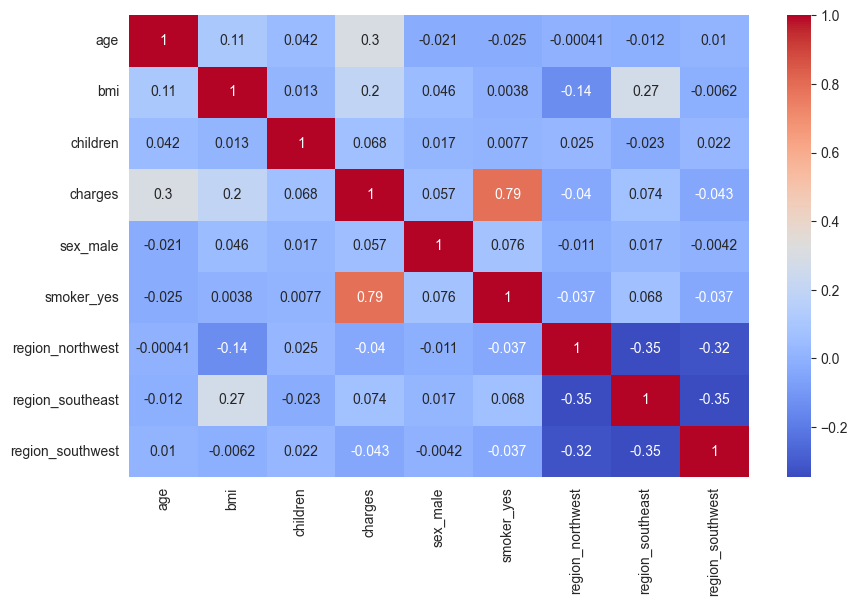

In [132]:
df_encoded = pd.get_dummies(df, drop_first=True)

#é possivel notar que as colunas smoker, age e bmi tem as correlacoes mais fortes. Concluimos que as regioes nao tem muita influencia na variavel target.

plt.figure(figsize=(10,6))
sns.heatmap(df_encoded.corr(), annot=True, cmap='coolwarm')
plt.show()

### Process and replace columns in the DataFrame

In [145]:
import numpy as np

# Fizemos alguns testes utilizando todas as colunas vs apenas as que tem maior correlacao com charges, e no final a diferenca nao foi significativa.
x = df.drop('charges', axis=1)
y = df['charges']

# Fit and transform the features
x_preprocessed = preprocessor.fit_transform(x)

# Get feature names
num_features = numerical_cols
cat_features = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols)
feature_names = np.concatenate([num_features, cat_features])

# Create a DataFrame with preprocessed features
X_preprocessed_df = pd.DataFrame(x_preprocessed, columns=feature_names)
X_preprocessed_df.reset_index(drop=True, inplace=True)
y = y.reset_index(drop=True)

# Verificando a estrutura dos dados preprocessados
X_preprocessed_df.head()


,age,bmi,children,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
0,-1.438764,-0.453320,-0.908614,0.0,1.0,0.0,0.0,1.0
1,-1.509965,0.509621,-0.078767,1.0,0.0,0.0,1.0,0.0
2,-0.797954,0.383307,1.580926,1.0,0.0,0.0,1.0,0.0
3,-0.441948,-1.305531,-0.908614,1.0,0.0,1.0,0.0,0.0
4,-0.513149,-0.292556,-0.908614,1.0,0.0,1.0,0.0,0.0


### Split the data into training and testing sets

In [134]:
from sklearn.model_selection import train_test_split, GridSearchCV

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X_preprocessed_df, y, test_size=0.30, random_state=42)

### Train the Decision Tree Regressor

In [135]:
from sklearn.tree import DecisionTreeRegressor

# Fizemos alguns testes com outros valores para o max_depth e concluimos que o max_depth de 5 se mostrou mais eficiente.
dt_classifier = DecisionTreeRegressor(random_state=42, criterion='squared_error', max_depth = 5)
dt_classifier.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=5, random_state=42)

### !!!Evaluate the model!!! -> verificar a necessidade de usar o .score vs r2_score.

In [148]:
from sklearn.metrics import r2_score

y_pred = dt_classifier.predict(X_test)
r_squared = r2_score(y_test, y_pred)

print("score: ", dt_classifier.score(X_train, y_train))
print("score: ", dt_classifier.score(X_test, y_test))

print('\nR2 Score:', r_squared)


score:  0.8770784786017006
score:  0.8555497993103209

R2 Score: 0.8555497993103209


### !!!Plot predicted vs actual charges!!! -> Tentar explicar o grafico

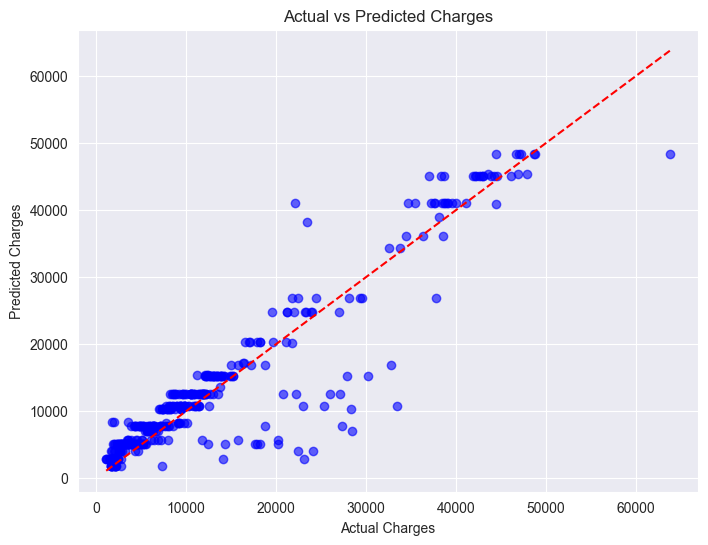

In [150]:
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Charges')
plt.ylabel('Predicted Charges')
plt.title('Actual vs Predicted Charges')
plt.show()


### Plot the decision tree

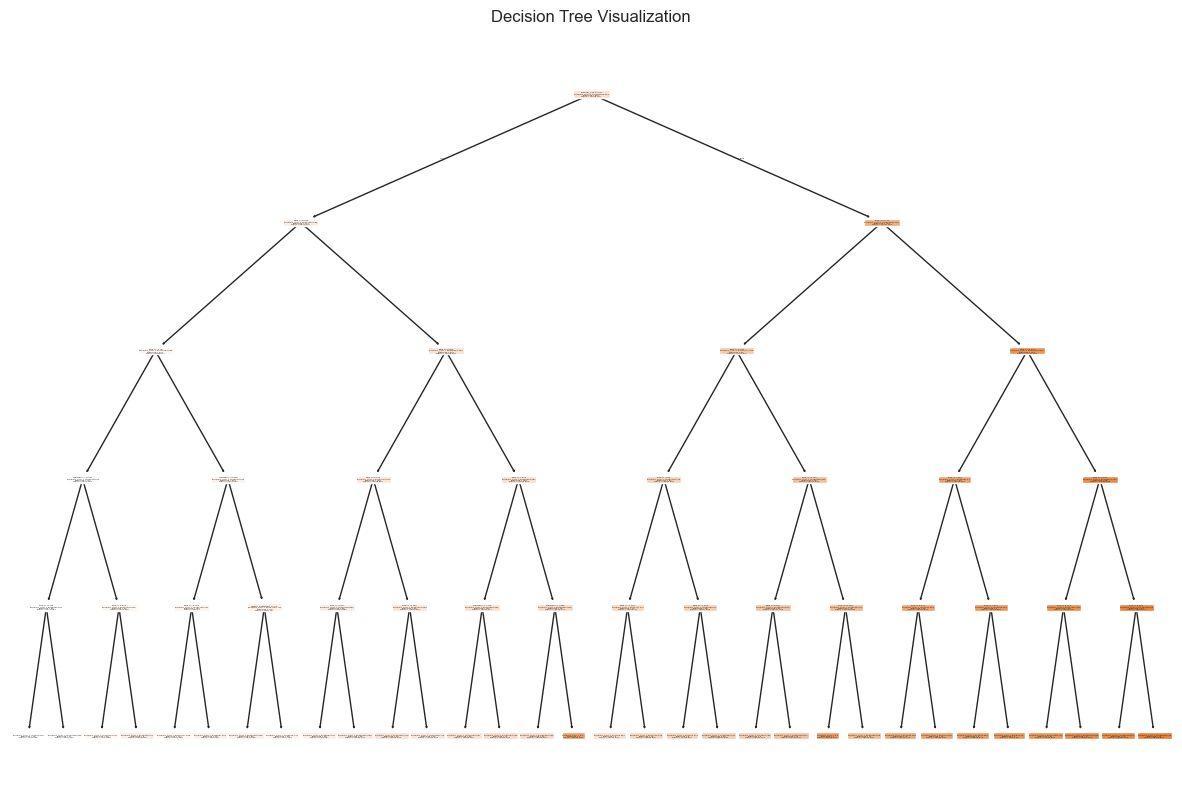

In [138]:
import matplotlib.pyplot as plt
from sklearn import tree

# Optional: Visualize the decision tree
plt.figure(figsize=(15, 10))
tree.plot_tree(
    dt_classifier,
    feature_names=feature_names,
    class_names=['Low', 'High'],
    filled=True
)
plt.title('Decision Tree Visualization')
plt.show()


## Random Forest Regressor

In [139]:
### Random Forest
from sklearn.ensemble import RandomForestRegressor
# Fizemos alguns testes com o n_estimators e max_depth e concluimos que o n_estimators de 6 e max_depth de 6 se mostrou mais eficiente.
rf = RandomForestRegressor(n_estimators=6, max_depth=6, random_state=7)

### train the model

In [140]:
rf.fit(X_train, y_train) 
estimator = rf.estimators_
y_predito_random_forest = rf.predict(X_test) 

### Evaluate the model

In [141]:
print (rf.score(X_train, y_train))
print(rf.score(X_test, y_test))


0.902766793070781
0.8635437751481823


In [142]:
from sklearn.metrics import r2_score

y_pred = dt_classifier.predict(X_test)
r_squared = r2_score(y_test, y_predito_random_forest)

# Este modelo se demonstrou o mais preciso na avaliação de charges.
print('\nR2 Score:', r_squared)


R2 Score: 0.8635437751481823


### Plot predicted vs actual charges

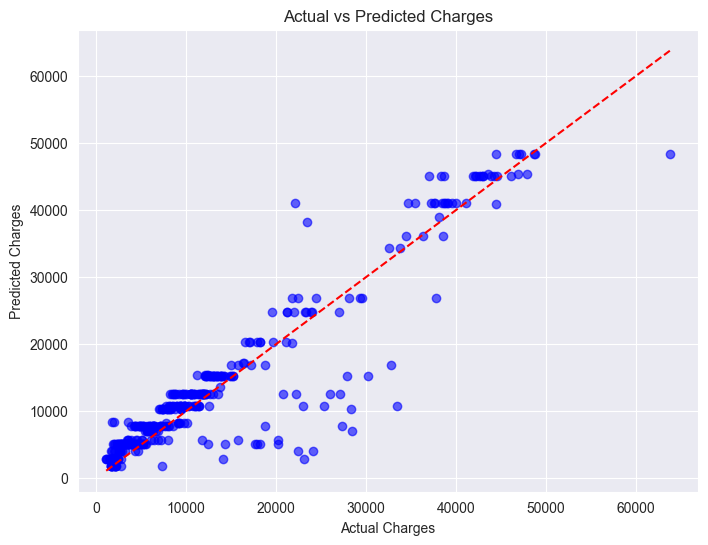

In [152]:
plt.figure(figsize=(8,6))
plt.scatter(y_test, y_pred, color='blue', alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Charges')
plt.ylabel('Predicted Charges')
plt.title('Actual vs Predicted Charges')
plt.show()


### Plot the decision tree

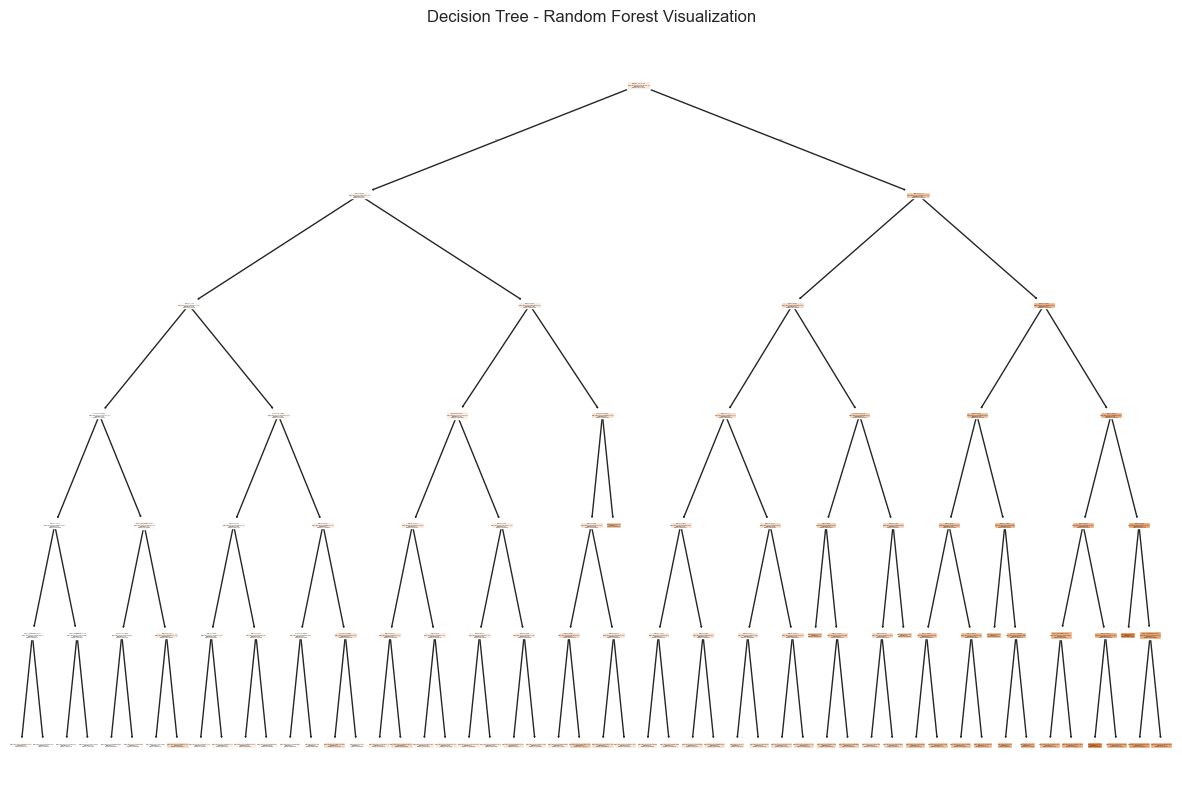

In [144]:
plt.figure(figsize=(15, 10))
tree.plot_tree(
    rf.estimators_[0],
    feature_names=feature_names,
    class_names=['Low', 'High'],
    filled=True
)
plt.title('Decision Tree - Random Forest Visualization')
plt.show()